# Zillow Project

In [13]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

import env
import acquire
import features
import evaluate
import split_scale

## Acquistion

In [14]:
df = acquire.wrangle_zillow()

## Explore

In [15]:
df.shape

(14892, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14892 entries, 0 to 14892
Data columns (total 8 columns):
bedroom_count     14892 non-null float64
bathroom_count    14892 non-null float64
square_feet       14892 non-null float64
property_value    14892 non-null float64
tax_paid          14892 non-null float64
tax_rate          14892 non-null float64
property_type     14892 non-null object
county_code       14892 non-null float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe()

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,county_code
count,14892.000000,14892.000000,14892.000000,1.489200e+04,14892.000000,14892.000000,14892.000000
mean,3.316143,2.324302,1938.497045,5.396460e+05,6564.370992,1.339895,6049.448429
std,0.926831,1.014254,992.488089,7.290735e+05,8428.010576,0.678182,21.272489
min,1.000000,1.000000,300.000000,1.050400e+04,51.260000,0.078687,6037.000000
25%,3.000000,2.000000,1276.000000,1.991870e+05,2710.622500,1.159710,6037.000000
50%,3.000000,2.000000,1678.000000,3.847785e+05,4762.040000,1.230339,6037.000000
75%,4.000000,3.000000,2342.250000,6.435572e+05,7637.557500,1.368188,6059.000000
max,11.000000,11.000000,15450.000000,2.385837e+07,276797.830000,45.288365,6111.000000


## Distribution of tax rates by county

- Identify the counties in the data and analyze the tax values

In [6]:
# Create column with county name instead of relying on county code.

df['county_name'] = df['county_code'].map({6037: "Los_Angeles_County", 6059: "Orange_County", 6111: "Ventura_County"})
df.head(1)

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,property_type,county_code,county_name
0,3.0,2.0,1458.0,136104.0,2319.9,1.704505,Single Family Residential,6037.0,Los_Angeles_County


In [7]:
# Create a dataframe that contains vital county tax information

df_county_tax = df[['county_code', 'county_name', 'tax_rate']]

In [8]:
df_county_tax.head(5)

,county_code,county_name,tax_rate
0,6037.0,Los_Angeles_County,1.704505
1,6037.0,Los_Angeles_County,1.526962
2,6037.0,Los_Angeles_County,1.249705
3,6037.0,Los_Angeles_County,1.191477
4,6037.0,Los_Angeles_County,1.230421


In [9]:
# Visualize distribution of county tax rate


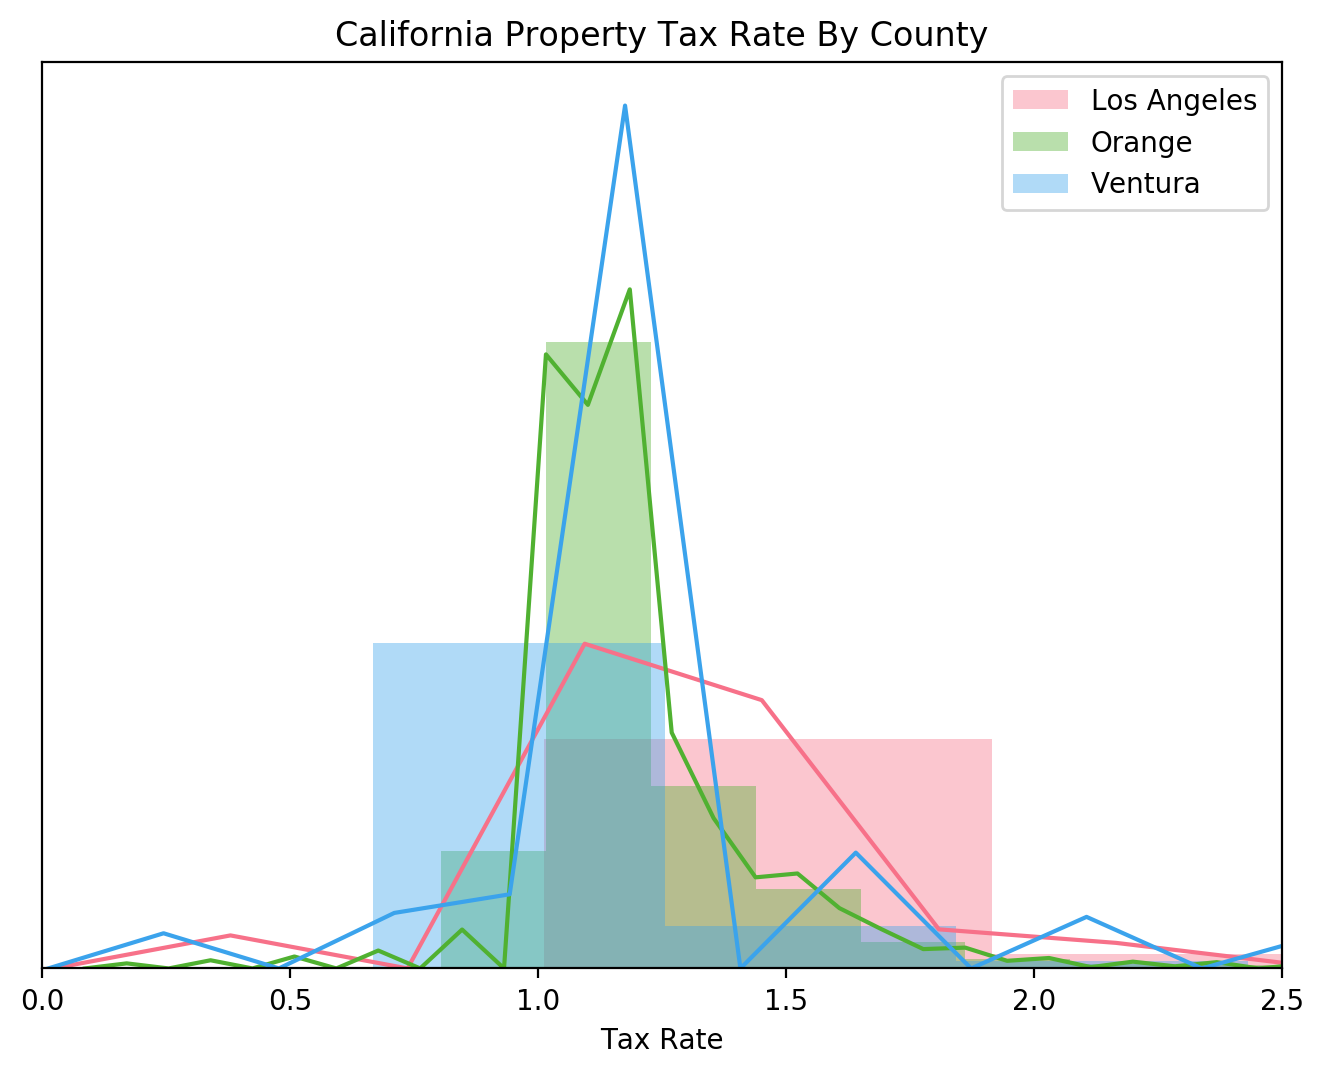

In [17]:
la_county = df_county_tax[df_county_tax.county_name == "Los_Angeles_County"].tax_rate
orange_county = df_county_tax[df_county_tax.county_name == 'Orange_County'].tax_rate
ventura_county = df_county_tax[df_county_tax.county_name == 'Ventura_County'].tax_rate

sns.set_palette("husl",3) 
plt.figure(figsize = (8,6), dpi = 200, facecolor = "w")
sns.distplot(la_county, label = "Los Angeles")
sns.distplot(orange_county, label = "Orange")
sns.distplot(ventura_county, label = "Ventura")
plt.xlim(0, 2.5)
plt.legend()
plt.yticks([])
plt.title("California Property Tax Rate By County")
plt.xlabel('Tax Rate')
plt.show()

## Split & Scale

- Create an X and y dataframe. Then split the data into train (X, y) and test (X, y) with a ratio of .80 for train and .20 for test. Also used a random_state equal to 123.

In [18]:
df.head()

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,property_type,county_code
0,3.0,2.0,1458.0,136104.0,2319.90,1.704505,Single Family Residential,6037.0
1,2.0,1.0,1421.0,35606.0,543.69,1.526962,Single Family Residential,6037.0
2,3.0,2.0,1650.0,614000.0,7673.19,1.249705,Single Family Residential,6037.0
3,2.0,1.0,693.0,274237.0,3267.47,1.191477,Single Family Residential,6037.0
4,3.0,2.0,1108.0,486866.0,5990.50,1.230421,Single Family Residential,6037.0


In [19]:
X = df[['bedroom_count', 'bathroom_count', 'square_feet']]
y = df[['property_value']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, random_state = 123)

In [20]:
len(X_train), len(X_test)

(11913, 2979)

In [23]:
X_train.shape, X_test.shape

((11913, 3), (2979, 3))

In [21]:
# Split data into train and test with all independent variables and the target variable
train, test = split_scale.split_my_data(df, .80, 123)
train.shape

(11913, 8)

- Scale the data using a standard scaler. The idea behind StandardScaler is that it will transform the data such that its distribution will have a mean value 0 and standard deviation of 1.

In [24]:
def standard_scaler(train, test):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train)
    train_scaled_data = scaler.transform(train)
    test_scaled_data = scaler.transform(test)
    train_scaled = pd.DataFrame(train_scaled_data, columns=train.columns).set_index([train.index])
    test_scaled = pd.DataFrame(test_scaled_data, columns=test.columns).set_index([test.index])
    return scaler, train_scaled, test_scaled

In [25]:
scaler, X_train_scaled, X_test_scaled = split_scale.standard_scaler(X_train, X_test)

In [26]:
len(X_train_scaled), len(X_test_scaled)

(11913, 2979)

## Explore

In [27]:
# Whole train dataset for the Explore phase
train.shape

(11913, 8)

- Correlation heatmap

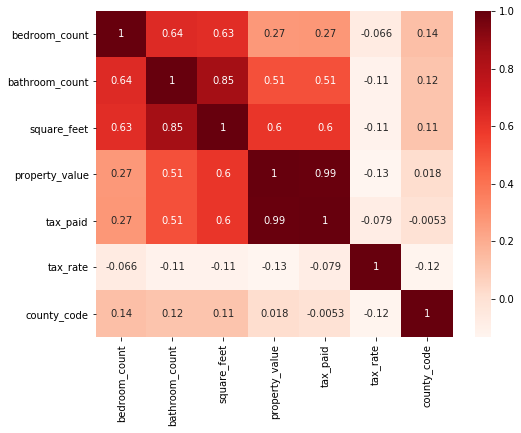

In [28]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)

- Estimate the relationship between multiple independent variables and a dependent variable using ordinary least squares (OLS) regression anaysis results

In [29]:
# OLS object

ols_model = sm.OLS(y_train, X_train_scaled)
regr = sm.OLS(y, X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         property_value   R-squared (uncentered):                   0.601
Model:                            OLS   Adj. R-squared (uncentered):              0.601
Method:                 Least Squares   F-statistic:                              7485.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):                        0.00
Time:                        15:12:47   Log-Likelihood:                     -2.1857e+05
No. Observations:               14892   AIC:                                  4.371e+05
Df Residuals:                   14889   BIC:                                  4.372e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedroom_count  -1.575e+05   4492.236    -35.070      0.000   -1.66e+05   -1.49e+05
bathroom_count  5.546e+04   9185.843      6.038      0.000    3.75e+04    7.35e+04
square_feet      482.5006      9.205     52.419      0.000     464.458     500.543
==============================================================================
Omnibus:                    24544.561   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44450047.899
Skew:                          10.677   Prob(JB):                         0.00
Kurtosis:                     269.795   Cond. No.                     4.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Plot the residuals of a feature and the target, of the dataframe

Text(0.5, 0, 'Bedroom Count')

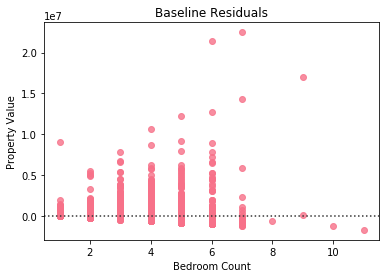

In [39]:
sns.residplot(train.bedroom_count, train.property_value)
plt.title(r'Baseline Residuals', fontsize=12, color='black')
plt.ylabel(r'Property Value')
plt.xlabel('Bedroom Count')

Text(0.5, 0, 'Bathroom Count')

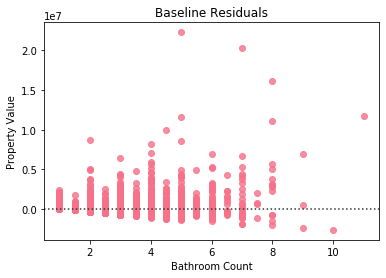

In [38]:
sns.residplot(train.bathroom_count, train.property_value)
plt.title(r'Baseline Residuals', fontsize=12, color='black')
plt.ylabel(r'Property Value')
plt.xlabel('Bathroom Count')

Text(0.5, 0, 'Square Footage')

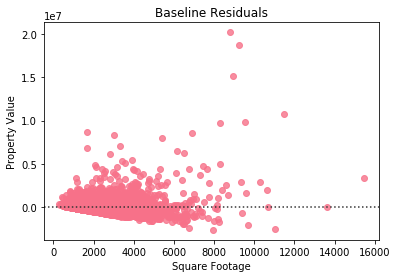

In [51]:
sns.residplot(train.square_feet, train.property_value)
plt.title(r'Baseline Residuals', fontsize=12, color='black')
plt.ylabel(r'Property Value')
plt.xlabel('Square Footage')

## Modeling

In [52]:
df.head(1)

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,property_type,county_code
0,3.0,2.0,1458.0,136104.0,2319.9,1.704505,Single Family Residential,6037.0


- Create a dataframe that contains the actual proper value, the linear regression model, and the baseline mean model

In [53]:
predictions = pd.DataFrame({'actual':y_train.property_value}).reset_index(drop=True)

lm1=LinearRegression()
lm1.fit(X_train_scaled[['bedroom_count', 'bathroom_count', 'square_feet']],y_train)
lm1_predictions=lm1.predict(X_train_scaled[['bedroom_count', 'bathroom_count', 'square_feet']])
predictions['lm1']=lm1_predictions

#Baseline

predictions['baseline'] = y_train.mean()[0]

- Create a better fitting line and print the formula of the line

In [54]:
lm1_y_intercept = lm1.intercept_

lm1_coefficients = lm1.coef_

print("intercept: ", lm1_y_intercept, "coefficients: ", lm1_coefficients)

intercept:  [544122.6294804] coefficients:  [[-143113.54507363   50253.20579737  502413.62852995]]


- Evaluation metrics for the baseline model to calculate baseline mean errors

In [55]:
SSE_baseline = mean_squared_error(predictions.actual, predictions.baseline) * len(predictions.actual)
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)

print("SSE_baseline: ", SSE_baseline, "MSE_baseline: ", MSE_baseline, "RMSE_baseline: ", RMSE_baseline, "R2_baseline: ", r2_baseline)

SSE_baseline:  6852659352003164.0 MSE_baseline:  575225329640.1548 RMSE_baseline:  758436.1078167064 R2_baseline:  0.0


- Evaluation metrics for the linear regression model to calculate the model's mean erros

In [56]:
SSE_lm1 = mean_squared_error(predictions.actual, predictions.lm1)*len(predictions.actual)
MSE_lm1 = mean_squared_error(predictions.actual, predictions.lm1)
RMSE_lm1 = sqrt(MSE_lm1)
r2_lm1 = r2_score(predictions.actual, predictions.lm1)

print("SSE_lm1", SSE_lm1, "MSE_lm1: ", MSE_lm1, "RMSE:", RMSE_lm1, "R2_lm1: ", r2_lm1)

SSE_lm1 4248654736244593.5 MSE_lm1:  356640202824.1915 RMSE: 597193.6058132167 R2_lm1:  0.37999913347471004


- Compare baseline model to linear regression model to determine which performs better by comparing each model's Squared Estimate of Errors (SSE)

In [57]:
# A lower SSE_lm1 than SSE_baseline is favorable

SSE_lm1 < SSE_baseline and MSE_lm1 < MSE_baseline

True

In [58]:
def model_significance(ols_model):
    r2 = ols_model.rsquared
    f_pval = ols_model.f_pvalue
    if f_pval < .05:
        return f'An R^2 of: {round(r2, 3)} and an F Statistic of: {round(f_pval, 4)} explains that the correlation between the model and the home value is significantly significant'
    else:
        return f'The correlation between the model and the home value is not significantly significant'

model_significance(regr)

'An R^2 of: 0.601 and an F Statistic of: 0.0 explains that the correlation between the model and the home value is significantly significant'

- The R^2 value of the linear regression model is greater than the baseline model and the error means are lesser than the baseline model's. These favorable resluts are due to adding the three features into the model.

## Model with test data

In [59]:
model = lm1.predict(X_test_scaled)
model = model.ravel().reshape(2979)
y_test1 = np.array(y_test).ravel().reshape(2979)
best_model=pd.DataFrame({'predictions':model,'property_value':y_test1})



In [62]:
best_model.head()

,predictions,property_value
0,598488.582089,534030.0
1,77839.381451,32666.0
2,212487.769513,185287.0
3,250239.166237,408898.0
4,331318.736508,288579.0


Text(0.5, 1, 'Predicted vs. Actual Home Value')

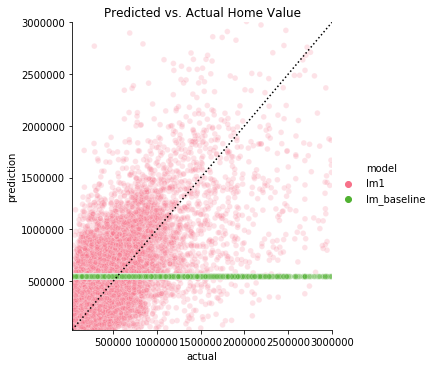

In [65]:
pd.DataFrame({'actual': predictions.actual,
              'lm1': predictions.lm1,
              'lm_baseline': predictions.baseline.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model', alpha = .2, s=32)
plt.plot([30000, 3000000],[30000, 3000000], c='black', ls=':')
plt.ylim(30000, 3000000)
plt.xlim(30000, 3000000)
plt.title('Predicted vs. Actual Home Value')